In [10]:
import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict, Counter

def calculate_maj_at_k(
    eval_folder, 
    model_name_prefix, 
    base_model, 
    task, 
    max_models=8, 
    max_samples=64,
):
    """
    Calculate majority voting accuracy@k metric
    
    Args:
    - eval_folder: Path to evaluation results folder
    - model_name_prefix: Model name prefix
    - baseline_model: Base model name (as step 0)
    - task: Task name
    - max_models: Maximum number of models to use
    - max_samples: Maximum samples per model
    
    Returns:
    - maj_at_k: Majority voting accuracy dict with keys (num_models, num_samples)
    """

    # Find all model folders
    model_step_folders = []
    for folder_name in os.listdir(eval_folder):
        folder_path = os.path.join(eval_folder, folder_name)
        if os.path.isdir(folder_path) and folder_name.startswith(model_name_prefix):
            step_match = re.search(r'(?:step|checkpoint)_?(\d+)', folder_name)
            if step_match:
                step_num = int(step_match.group(1))
                model_step_folders.append((step_num, folder_path))
    
    # Add base model as step 0
    base_path = os.path.join(eval_folder, base_model)
    if os.path.isdir(base_path):
        model_step_folders.append((0, base_path))
    
    model_step_folders = sorted(model_step_folders, key=lambda x: x[0])
    
    if not model_step_folders:
        print(f"No matching model folders found")
        return {}
    
    # Store answer data for all problems: {problem_id: {step: [(answer, is_correct), ...]}}
    problem_answers = defaultdict(lambda: defaultdict(list))
    all_problem_ids = set()
    
    # Process evaluation results for each model
    for step_num, model_path in model_step_folders:
        result_file = os.path.join(model_path, f"model_final_answer_{task}.json")
        
        if not os.path.exists(result_file):
            print(f"Warning: Evaluation file not found: {result_file}")
            continue
        
        try:
            with open(result_file, 'r', encoding='utf-8') as f:
                eval_data = json.load(f)
            
            for problem in eval_data:
                problem_id = problem.get("index", -1)
                
                if problem_id >= 0:
                    all_problem_ids.add(problem_id)
                    
                    for response in problem.get("responses", []):
                        answer = response.get("resp_answer", "")
                        is_correct = response.get("llm_check_result") == 1
                        problem_answers[problem_id][step_num].append((answer, is_correct))
        
        except (json.JSONDecodeError, FileNotFoundError) as e:
            print(f"Error: Cannot read file {result_file}: {e}")
    
    # Get all steps and sort in reverse order
    all_steps = sorted(list(set().union(*[step_dict.keys() for step_dict in problem_answers.values()])))
    step_sequence = sorted(all_steps, reverse=True)
    
    print(f"Using step sequence: {step_sequence[:max_models]}")
    
    def distribute_samples_evenly(total_samples, num_models):
        """Distribute total samples evenly across models"""
        base_count = total_samples // num_models
        extra_count = total_samples % num_models
        
        distribution = [base_count] * num_models
        for i in range(extra_count):
            distribution[i] += 1
        
        return distribution

    # Shuffle answer order for each problem at each step
    for prob_id in all_problem_ids:
        for step in all_steps:
            if step in problem_answers.get(prob_id, {}):
                random.shuffle(problem_answers[prob_id][step])

    # Calculate majority voting accuracy for different (num_models, num_samples) combinations
    maj_at_k = {}
    total_problems = len(all_problem_ids)
    
    for num_models in range(1, min(len(step_sequence), max_models) + 1):
        used_steps = step_sequence[:num_models]
        
        for num_samples in range(1, max_samples + 1):
            correct_predictions = 0
            sample_distribution = distribute_samples_evenly(num_samples, num_models)
            
            for prob_id in all_problem_ids:
                all_candidate_answers = []
                correct_answer_set = set()
                
                # Collect answers from each model
                for model_idx, step in enumerate(used_steps):
                    responses = problem_answers.get(prob_id, {}).get(step, [])
                    samples_needed = sample_distribution[model_idx]
                    actual_samples = min(samples_needed, len(responses))
                    
                    for i in range(actual_samples):
                        answer, is_correct = responses[i]
                        all_candidate_answers.append(answer)
                        if is_correct:
                            correct_answer_set.add(answer)
                
                if not all_candidate_answers:
                    continue
                
                # Find most frequent answer as majority vote result
                answer_frequency = Counter(all_candidate_answers)
                most_frequent_answers = answer_frequency.most_common()
                
                max_frequency = most_frequent_answers[0][1]
                majority_candidates = [ans for ans, freq in most_frequent_answers if freq == max_frequency]
                majority_answer = majority_candidates[0]
                
                # Check if majority vote answer is correct
                if majority_answer in correct_answer_set:
                    correct_predictions += 1
            
            maj_at_k[(num_models, num_samples)] = (correct_predictions / total_problems) * 100 if total_problems else 0
    
    return maj_at_k






In [11]:
def calculate_maj_at_k_with_multiple_runs(
    eval_folder, 
    model_name_prefix, 
    base_model, 
    task, 
    max_models=8, 
    max_samples=32,
    num_runs=10
):
    """
    Run multiple times and calculate average majority voting accuracy
    
    Args:
    - Same as calculate_maj_at_k
    - num_runs: Number of runs
    
    Returns:
    - average_results: Average results from multiple runs
    """
    all_run_results = {}
    
    print(f"Starting multiple runs calculation, total {num_runs} runs...")
    
    for run_idx in range(num_runs):
        print(f"Run {run_idx+1}/{num_runs}...")
        
        single_run_result = calculate_maj_at_k(
            eval_folder, 
            model_name_prefix, 
            base_model, 
            task, 
            max_models=max_models, 
            max_samples=max_samples,
        )
        
        for key, value in single_run_result.items():
            if key not in all_run_results:
                all_run_results[key] = []
            all_run_results[key].append(value)
    
    # Calculate average
    average_results = {}
    for key, values in all_run_results.items():
        average_results[key] = sum(values) / len(values)
    
    print(f"Completed {num_runs} runs and calculated average")
    return average_results

In [12]:

eval_folder = "../sampling_64_responses"
model_name_prefix = "UWNSL__Qwen2.5-7B-deepscaler_4k_step_"
base_model = "Qwen__Qwen2.5-7B"
task = "AIME"

average_maj_at_k = calculate_maj_at_k_with_multiple_runs(
    eval_folder, 
    model_name_prefix, 
    base_model, 
    task, 
    max_models=8, 
    max_samples=64, 
    num_runs=100  
)


Starting multiple runs calculation, total 100 runs...
Run 1/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 2/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 3/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 4/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 5/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 6/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 7/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 8/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 9/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 10/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 11/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 12/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 13/100...
Using step sequence: [256, 224, 192, 160, 128, 96, 64, 32]
Run 14

In [7]:
import json

output_file_path = 'exp_results/maj_at_k_results_AIME_Qwen2.5-7B_RL.json'
converted_dict = {f"{t}_{m}": value for (t, m), value in average_maj_at_k.items()}
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(converted_dict, f, indent=2)

print(f"Dictionary Saved in: {output_file_path}")

Dictionary Saved in: exp_results/maj_at_k_results_AIME_Qwen2.5-7B_RL.json


Chart saved as: exp_results/maj_at_k_results_AIME_Qwen2.5-7B_RL_plot.png


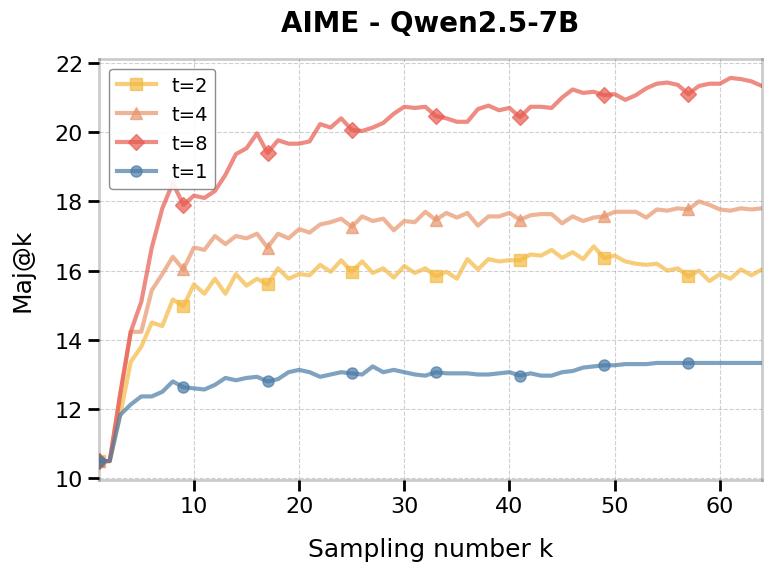

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_maj_at_k(filename, title=None, figsize=(8, 6)):
    """
    Plot Pass@k chart for a single data file
    
    Parameters:
    - filename: path to data file
    - title: chart title, auto-generated if None
    - figsize: chart dimensions
    """
    
    # Set clear and readable font configurations
    plt.rcParams.update({
        'font.size': 16,           
        'axes.titlesize': 20,      
        'axes.labelsize': 18,      
        'xtick.labelsize': 16,     
        'ytick.labelsize': 16,     
        'legend.fontsize': 14      
    })
    
    # Color and style configurations
    temporal_colors = {
        1: '#4A7BA7',    # Cool tone - dedicated for t=1 (fresh blue)
        2: '#F4B942',    # Warm tone - bright yellow
        4: '#E8956B',    # Warm tone - coral red
        8: '#E85A4F'     # Warm tone - warm orange
    }
    
    temporal_markers = {
        1: 'o',     # Circle - dedicated for t=1
        2: 's',     # Square
        4: '^',     # Triangle
        8: 'D'      # Diamond
    }
    
    temporal_linestyles = {
        1: '-',     # Solid line
        2: '-',     # Solid line
        4: '-',     # Solid line
        8: '-'      # Solid line
    }
    
    temporal_linewidths = {
        1: 3,       # t=1 thicker
        2: 3,
        4: 3,
        8: 3
    }
    
    temporal_markersizes = {
        1: 8,       # t=1 slightly larger
        2: 8,
        4: 8,
        8: 8
    }
    
    temporal_values = [1, 2, 4, 8]
    
    # Create chart
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    try:
        # Load data
        with open(filename, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
        
        # Restore tuple keys
        parsed_results = {tuple(map(int, key.split('_'))): value for key, value in raw_data.items()}
        
        # Get all available m values
        all_sampling_numbers = sorted(list(set(m for _, m in parsed_results.keys())))
        
        # First plot t=2,4,8 lines (background layer)
        for t in [2, 4, 8]:
            temporal_pass_rates = []
            for sampling_num in all_sampling_numbers:
                current_pass_rate = parsed_results.get((t, sampling_num), 0)
                temporal_pass_rates.append(current_pass_rate)
            
            # Adjust marker density based on data point count
            marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
            
            ax.plot(all_sampling_numbers, temporal_pass_rates, 
                    label=f't={t}',
                    color=temporal_colors[t], 
                    marker=temporal_markers[t], 
                    markersize=temporal_markersizes[t],
                    linewidth=temporal_linewidths[t],    
                    linestyle=temporal_linestyles[t],
                    markevery=marker_frequency,
                    alpha=0.7)
        
        # Finally plot t=1 line (foreground layer, most prominent)
        t = 1
        temporal_pass_rates = []
        for sampling_num in all_sampling_numbers:
            current_pass_rate = parsed_results.get((t, sampling_num), 0)
            temporal_pass_rates.append(current_pass_rate)
        
        marker_frequency = 8 if len(all_sampling_numbers) <= 100 else 15
        
        ax.plot(all_sampling_numbers, temporal_pass_rates, 
                label=f't={t}',
                color=temporal_colors[t], 
                marker=temporal_markers[t], 
                markersize=temporal_markersizes[t],
                linewidth=temporal_linewidths[t],
                linestyle=temporal_linestyles[t],
                markevery=marker_frequency,
                alpha=0.7,
                zorder=10)  # Ensure it's in the foreground
        
        # Set chart properties
        if title is None:
            # Auto-generate title from filename
            title = filename.split('/')[-1].replace('.json', '').replace('_', ' ').title()
        
        ax.set_title(title, fontsize=20, pad=20, weight='bold')
        ax.set_xlabel('Sampling number k', fontsize=18, labelpad=15)
        ax.set_ylabel('Maj@k', fontsize=18, labelpad=15)
        
        # Set grid and axes
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_xlim(1, max(all_sampling_numbers))
        
        # Set borders and ticks
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_alpha(0.2)
        
        ax.tick_params(width=2, length=8, labelsize=16)
        
        # Add legend
        ax.legend(fontsize=14, frameon=True, framealpha=0.9, edgecolor='gray')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save charts
        output_png_path = filename.replace('.json', '_plot.png')
        plt.savefig(output_png_path, dpi=150, bbox_inches='tight')
        plt.savefig(output_png_path.replace('.png', '.pdf'), bbox_inches='tight')
        
        print(f"Chart saved as: {output_png_path}")
        plt.show()
        
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"Error during plotting: {e}")

# Usage example
if __name__ == "__main__":
    # Plot chart for specified file
    plot_maj_at_k(
        'exp_results/maj_at_k_results_AIME_Qwen2.5-7B_RL.json',
        title='AIME - Qwen2.5-7B'
    )